In [1]:
import urllib.request
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# scrape Euroleaks

In [2]:
# each group has a different html structure
leaks_short = {1: [
            'feb24eurogroup/',
            'mar17ewg/',
            'apr1ewg/',
            'apr24eurogroup/',
            'may11eurogroup/',
            'jun18eurogroup/',
            'jun22eurogroup/',
            'jun24eurogroup/',
            'jun25eurogroup-part1/',
            'jun27eurogroup/',
            'jun30eurogroup/'
            ],
         2: ['jul1eurogroup/'],
         3: ['jun25eurogroup-part-2/']
        }

leaks = {
    group: [{
        'url': f'https://euroleaks.diem25.org/leaks/{leak}',
        'short': leak[:-1]}
        for leak in urls_] for group, urls_ in leaks_short.items() 
}

download HTML pages containing the transcripts

In [10]:
for leaks_ in leaks.values():
    for leak in leaks_:
        urllib.request.urlretrieve(leak['url'], f'data/euroleaks/html/{leak["short"]}.html')

parse with BeatifulSoup, construct Pandas dataframe

In [309]:
def format_timestamp(s):
    if re.compile('\(\d{2}:\d{2}:\d{2}\)').match(s):
        return pd.to_datetime(s, format='(%H:%M:%S)')
    elif re.compile('\(\d{2}:\d{2}\)').match(s):
        return pd.to_datetime(s, format='(%M:%S)', errors='coerce')
    else:
        return np.datetime64('NaT')

In [310]:
dfs = []

speaker_regex = '^([\w*\[\]] *)*'

for group, leaks_ in leaks.items():
    
    for leak in leaks_:
        
        with open(f'data/euroleaks/html/{leak["short"]}.html', 'r') as page:
            
            content = page.read()
            soup = BeautifulSoup(content, 'html.parser')

            date = soup.find(class_='post-date').find(class_='meta-text').text.strip()
    
            col_speaker = []
            col_speech = []
            col_timestamp = []
        
            if group == 1:

                interventions = soup.find(id='transcript_without_translation').find_all(class_='intervention')

                for intervention in interventions:
                    # get speaker name
                    col_speaker.append(re.search(speaker_regex, intervention.find(class_='speaker-name').text).group())
                    # get speech
                    col_speech.append(intervention.find(class_='speech').text)
                    # get timestamp
                    timestamp_ = intervention.find(class_='timestamp')
                    col_timestamp.append(format_timestamp(timestamp_.text) if timestamp_ else np.datetime64('NaT'))

            elif group == 2:
            
                paragraphs = soup.find(id='transcript_without_translation').find_all('p')
            
                last_speaker = np.nan

                for p in paragraphs: 
    
                    have_speaker = False
                    speech = ''
    
                    timestamp_ = p.find(class_='timestamp')
    
                    for line in p.text.split('\n'):
                        if line.endswith(':'):
                            if have_speaker:
                                col_speaker.append(last_speaker)
                                col_speech.append(speech.strip())
                                col_timestamp.append(format_timestamp(timestamp_.text) if timestamp_ else np.datetime64('NaT'))
                            else:
                                have_speaker = not have_speaker
                
                            last_speaker = re.search(speaker_regex, line).group()
                            speech = '' 
                        else:
                            speech = '\n'.join((speech, line.strip()))
            
                    col_speaker.append(last_speaker)
                    col_speech.append(speech.strip())
                    col_timestamp.append(format_timestamp(timestamp_.text) if timestamp_ else np.datetime64('NaT'))

            elif group == 3:
            
                paragraphs = soup.find(id='transcript_without_translation').find_all('p')
                
                last_speaker = np.nan
                timestamp = np.datetime64('NaT')

                for p in paragraphs:
    
                    if p.text.endswith(':'):
                        last_speaker = re.search(speaker_regex, p.text).group()
                        timestamp = re.search('\(\d{2}:\d{2}\)', p.text).group() if re.search('\(\d{2}:\d{2}\)', p.text) else np.nan
        
                    else:
                        col_speaker.append(last_speaker)
                        col_speech.append(p.text)
                        if not pd.isnull(timestamp):
                            col_timestamp.append(format_timestamp(timestamp))
                            timestamp = np.datetime64('NaT')
                        else:
                            col_timestamp.append(np.datetime64('NaT'))
                
                
            dfs.append(pd.DataFrame({
                'speaker': col_speaker,
                'speech': col_speech,
                'timestamp': col_timestamp,
                'date': pd.to_datetime(np.repeat(date, len(col_timestamp)))
                }))

leaks_df = pd.concat(dfs, ignore_index=True)

In [312]:
leaks_df.head()

,speaker,speech,timestamp,date
0,Jeroen Dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24
1,Speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24
2,Michael Noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24
3,Speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24
4,Speaker 3,Has entered the conference.,1900-01-01 00:01:33,2015-02-24


In [49]:
# print the whole transcript for a given date
for row in leaks_df[leaks_df.date == pd.to_datetime('July 1, 2015')].iterrows():
    print(f'\n{row[1].speaker} ({row[1].timestamp}):\n{row[1].speech}')


nan (NaT):
Jeroen Dijsselbloem
Now, let’s see who is on the line. Ireland? Germany?
(inaudible greetings)

Jeroen Dijsselbloem  (1900-01-01 00:01:42):
Colleagues, Jeroen here. Are we complete? Anyone still missing?

Male (1900-01-01 00:01:42):
– Jeroen, we are missing Germany. We have sent a message.

Jeroen Dijsselbloem (NaT):
We’ll wait for a few seconds. We picked this time especially for Wolfgang. So…we ll wait a couple of minutes.

Male  (1900-01-01 00:02:44):
Jeroen, we should be complete.

Jeroen Dijsselbloem (NaT):
Thanks a lot. Uh, welcome everyone. This second conference call in two days has the purpose to come back to the two letters that were sent yesterday by the Greek Prime Minister, one to me and one to the Institutions. Um, but I think it is enough to be (inaudible) inevitable that we also reflect on the last speech by Prime Minister Tsipras this afternoon, which was again a very clear political stance.

Jeroen Dijsselbloem (NaT):
Um, the, the two letters, the first on

## clean Euroleaks

In [2]:
df = pd.read_csv('data/euroleaks/prepared.csv')
df.head()

,speaker,speech,timestamp,date
0,Jeroen Dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,Speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,Michael Noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,Speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,Speaker 3,Has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00


### todo
- need to check that timestamp is monotonically increasing
- derive speech duration from timestamp (after checking and correcting if need be)
- fill missing timestamps by taking time between the next ones, then allocating to ones in between with missing based on word/character count
- check speakers (then maybe exclude "Computer")
- clean "[inaudible]", "[crosstalk]", "[foreign language]", also (*)
- check for special character to see for other things that need to be potentially cleaned


### speakers

In [4]:
df[df.speaker.isnull()]

,speaker,speech,timestamp,date
1394,NaN,"Jeroen Dijsselbloem\nNow, let’s see who is on ...",NaN,2015-07-01 00:00:00


In [5]:
df.loc[df.speaker.isnull()].speaker = 'jeroen dijsselbloem'

/home/asajina/.local/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
df.speaker.unique().size

102

In [7]:
df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s).unique()

array(['jeroen dijsselbloem', 'speaker 2', 'michael noonan', 'speaker 3',
       'pierre moscovici', 'mario draghi', 'wolfgang schäuble',
       'christine lagarde', 'yanis varoufakis', 'yanis [not varoufakis]',
       'luis de guindos', 'maria luís', 'marco buti', 'thomas wieser',
       'declan costello', 'computer', 'speaker 5', 'benoit couré',
       'paul thomsen', 'greek representative', 'speaker 9', 'thomas',
       'speaker 10', 'speaker 1', 'benoit cœuré', 'nikos theocarakis',
       'irina', 'irana', 'nabil', 'speaker 4', 'tooma', 'tropa',
       'speaker 6', 'ricci', 'speaker 7', 'speaker 8', 'hans',
       'speaker 11', 'speaker 12', 'speaker 13', 'speaker 14', 'paul',
       'klaus regling', 'peter kažimír', 'martin', 'hans jörg schelling',
       'dušan mramor', 'michel sapin', 'pier carlo padoan', 'speaker 19',
       'edward scicluna', 'rimantas šadžius', 'poul thomsen',
       'alexander stubb', 'inaudible', 'yanis varoufakis [privately]',
       'johan van overtveldt'

In [8]:
for speaker in df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s).unique():
    if not pd.isnull(speaker) and 'alex' in speaker:
        print(speaker)

alexander stubb


In [9]:
amend_names = {
    'wolfgang schäuble': [
        'wolfgang schäuble',
        'wolfgang schauble',
        'wolfgang'
    ],
    'thomas wieser': [
        'thomas wieser',
        'thomas'
    ],
    'peter kažimír': [
        'peter kažimír',
        'peter kazimir'
    ],
    'michel sapin': [
        'michel sapin',
        'michel'
    ],
    'maria luís albuquerque': [
        'maria luís albuquerque',
        'maria luís',
        'maria luis albuquerque'
    ],
    'johan van overtveldt': [
        'johan van overtveldt',
        'johan'
    ],
    'benoît cœuré': [
        'benoît cœuré',
        'benoit couré',
        'benoit cœuré'
    ],
    'hans jörg schelling': [
        'hans jörg schelling',
        'hans'
    ],
    'poul mathias thomsen': [
        'paul thomsen',
        'paul',
        'poul thomsen'
    ]
}

In [10]:
# invert dict
amend_names_inv = {value: key for key,values in amend_names.items() for value in values}

In [11]:
# strip and make lowercase
df.speaker = df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s)
# amend speaker names
df.speaker = df.speaker.apply(lambda s: amend_names_inv[s] if s in amend_names_inv.keys() else s)

In [12]:
df.speaker.unique()

array(['jeroen dijsselbloem', 'speaker 2', 'michael noonan', 'speaker 3',
       'pierre moscovici', 'mario draghi', 'wolfgang schäuble',
       'christine lagarde', 'yanis varoufakis', 'yanis [not varoufakis]',
       'luis de guindos', 'maria luís albuquerque', 'marco buti',
       'thomas wieser', 'declan costello', 'computer', 'speaker 5',
       'benoît cœuré', 'poul mathias thomsen', 'greek representative',
       'speaker 9', 'speaker 10', 'speaker 1', 'nikos theocarakis',
       'irina', 'irana', 'nabil', 'speaker 4', 'tooma', 'tropa',
       'speaker 6', 'ricci', 'speaker 7', 'speaker 8',
       'hans jörg schelling', 'speaker 11', 'speaker 12', 'speaker 13',
       'speaker 14', 'klaus regling', 'peter kažimír', 'martin',
       'dušan mramor', 'michel sapin', 'pier carlo padoan', 'speaker 19',
       'edward scicluna', 'rimantas šadžius', 'alexander stubb',
       'inaudible', 'yanis varoufakis [privately]',
       'johan van overtveldt', 'unidentified speaker', 'kian', 'mal

### word count by speaker

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.speech)

In [15]:
X.toarray().shape

(1522, 5266)

In [16]:
print(vectorizer.get_feature_names())

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '107', '11', '111', '114', '11pm', '11th', '12', '120', '13', '13th', '14', '15', '150', '16', '17', '18', '185', '19', '1999', '1st', '20', '200', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2025', '20th', '21', '21st', '22', '22nd', '23', '23rd', '24', '24th', '25', '250', '25th', '26', '27', '27th', '28', '29', '29th', '30', '300', '30th', '31', '31st', '32', '33', '34', '340', '35', '36', '37', '38', '39', '3rd', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '500', '50th', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5th', '60', '64', '67', '6th', '70', '700', '71', '75', '80', '85', '87', '8th', '90', '93', '96', '9th', 'a9', 'abeyance', 'abide', 'ability', 'able', 'ablt', 'aboard', 'abound', 'about', 'above', 'abroad', 'absence', 'absolute', 'absolutely', 'abstract', 'abundantly', 'abuse', 'abused', 'abuses', 'acas', '

In [17]:
df['wordcount'] = X.toarray().sum(axis=1)

In [18]:
wc_by_speaker = df.groupby('speaker')['wordcount'].sum()

In [19]:
wc_by_speaker.describe()

count       66.000000
mean      1582.818182
std       3768.963179
min          3.000000
25%        170.000000
50%        455.000000
75%       1206.000000
max      24241.000000
Name: wordcount, dtype: float64

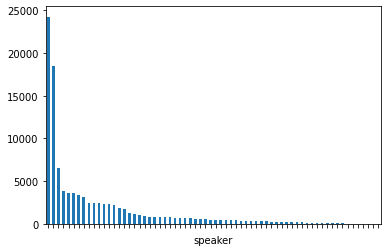

In [20]:
ax = wc_by_speaker.sort_values(ascending=False).plot.bar()
labels = ax.set_xticklabels([])

<AxesSubplot:xlabel='speaker'>

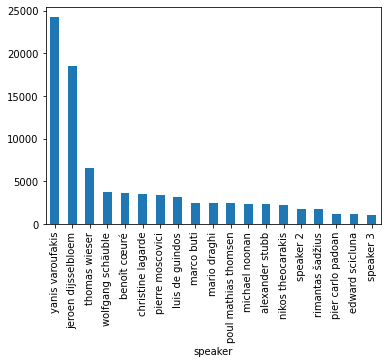

In [21]:
wc_by_speaker[wc_by_speaker > 1000].sort_values(ascending=False).plot.bar()

### word count by entity

In [25]:
df['entity'] = df.speaker.apply(lambda s: speaker_to_entity[s] if s in speaker_to_entity.keys() else 'unkown')

In [26]:
wc_by_entity = df.groupby('entity')['wordcount'].sum()

In [27]:
wc_by_entity

entity
austria                  597
belgium                  448
cyprus                   603
ecb                     6082
efc                     6572
esm                      610
eurogroup president    18502
european commission     6827
finland                 2351
france                   347
germany                 3784
greece                 26607
imf                     5990
ireland                 2352
italy                   1218
lithuania               1783
malta                   1170
portugal                 690
slovakia                 436
slovenia                 161
spain                   3189
unkown                 14161
Name: wordcount, dtype: int64

<AxesSubplot:xlabel='entity'>

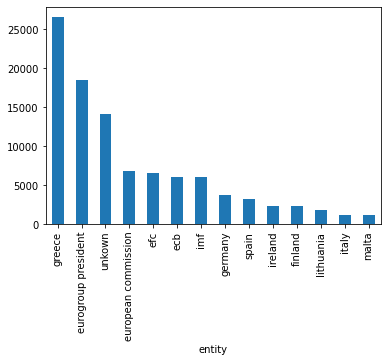

In [28]:
wc_by_entity[wc_by_entity > 1000].sort_values(ascending=False).plot.bar()

#### group institutions together

In [29]:
wcent = pd.DataFrame({
    'total': wc_by_entity,
    'countries': wc_by_entity,
    'european commission': np.zeros(wc_by_entity.size, dtype=int),
    'efc': np.zeros(wc_by_entity.size, dtype=int),
    'ecb': np.zeros(wc_by_entity.size, dtype=int),
    'imf': np.zeros(wc_by_entity.size, dtype=int)
})

wcent.loc['institutions'] = np.array([
    0,
    0,
    wc_by_entity.loc['european commission'],
    wc_by_entity.loc['efc'],
    wc_by_entity.loc['ecb'],
    wc_by_entity.loc['imf']
])

wcent['countries'][(wcent.index.to_numpy() == 'efc') | (wcent.index.to_numpy() == 'ecb') | (wcent.index.to_numpy() == 'imf') | (wcent.index.to_numpy() == 'european commission')] = 0

<AxesSubplot:xlabel='entity'>

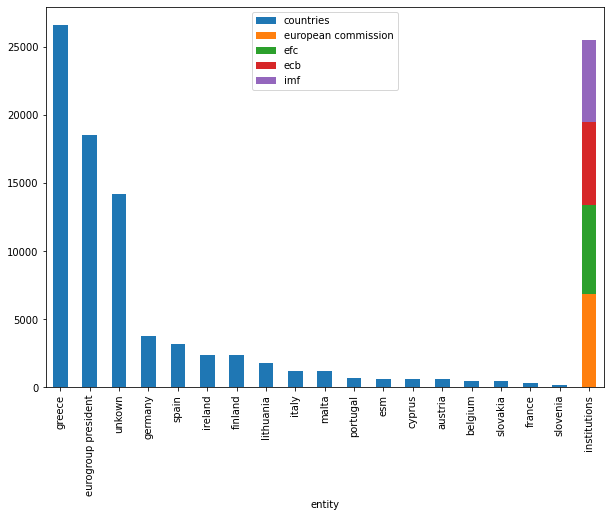

In [30]:
wcent.sort_values(by='total', ascending=False).drop(columns=['total'], index=['european commission', 'efc', 'ecb', 'imf']).plot.bar(stacked=True, figsize=(10,7))

## auxiliary data

- map speaker to entity (finance minister of country, ECB, IMF) DONE
- map date to total duration of call, to be able to get speech duration for last speech entry for a date

In [82]:
speaker_to_entity = {
    'jeroen dijsselbloem': 'eurogroup president', # the netherlands
    'michael noonan': 'ireland',
    'pierre moscovici': 'european commission',
    'mario draghi': 'ecb',
    'wolfgang schäuble': 'germany',
    'christine lagarde': 'imf',
    'yanis varoufakis': 'greece',
    'luis de guindos': 'spain',
    'maria luís albuquerque': 'portugal',
    'marco buti': 'european commission',
    'thomas wieser': 'efc', # economic and financial committee
    'declan costello': 'european commission', #dg ecfin
    'benoît cœuré': 'ecb',
    'poul mathias thomsen': 'imf',
    'greek representative': 'greece',
    'nikos theocarakis': 'greece',
    'hans jörg schelling': 'austria',
    'klaus regling': 'esm', # head of european stability mechanism
    'peter kažimír': 'slovakia',
    'dušan mramor': 'slovenia',
    'michel sapin': 'france',
    'pier carlo padoan': 'italy',
    'edward scicluna': 'malta',
    'rimantas šadžius': 'lithuania',
    'alexander stubb': 'finland',
    'johan van overtveldt': 'belgium',
    'harris georgiades': 'cyprus',
    'luis pierre': 'european commission'
}

In [153]:
df.speaker.unique()

array(['jeroen dijsselbloem', 'speaker 2', 'michael noonan', 'speaker 3',
       'pierre moscovici', 'mario draghi', 'wolfgang schäuble',
       'christine lagarde', 'yanis varoufakis', 'yanis [not varoufakis]',
       'luis de guindos', 'maria luís albuquerque', 'marco buti',
       'thomas wieser', 'declan costello', 'computer', 'speaker 5',
       'benoît cœuré', 'poul mathias thomsen', 'greek representative',
       'speaker 9', 'speaker 10', 'speaker 1', 'nikos theocarakis',
       'irina', 'irana', 'nabil', 'speaker 4', 'tooma', 'tropa',
       'speaker 6', 'ricci', 'speaker 7', 'speaker 8',
       'hans jörg schelling', 'speaker 11', 'speaker 12', 'speaker 13',
       'speaker 14', 'klaus regling', 'peter kažimír', 'martin',
       'dušan mramor', 'michel sapin', 'pier carlo padoan', 'speaker 19',
       'edward scicluna', 'rimantas šadžius', 'alexander stubb',
       'inaudible', 'yanis varoufakis [privately]',
       'johan van overtveldt', 'unidentified speaker', 'kian', 'mal

In [166]:
for speaker in df.speaker.unique():
    if not pd.isnull(speaker) and 'speaker' in speaker:
        print(speaker)

speaker 2
speaker 3
speaker 5
speaker 9
speaker 10
speaker 1
speaker 4
speaker 6
speaker 7
speaker 8
speaker 11
speaker 12
speaker 13
speaker 14
speaker 19
unidentified speaker
speaker 16
speaker 20
speaker 17
speaker 18
speaker 21
speaker


# scrape commnuniques

In [265]:
communiques = [
    'https://www.consilium.europa.eu/en/press/press-releases/2015/02/12/dijsselbloem-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/02/16/eurogroup-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/02/20/eurogroup-statement-greece/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/02/20/eurogroup-press-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/02/24/eurogroup-statement-greece/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/04/24/eurogroup-dijsselbloem-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/05/11/eurogroup-statement-greece/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/05/11/eurogroup-jd-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/18/press-remarks-eurogroup-president/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/22/eurogroup-press-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/24/eurogroup-exit-doorstep/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/25/eurogroup-exit-doorstep/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/27/eurogroup-statement-greece/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/27/eurogroup-intermediary-press-remarks/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/27/ministerial-statement/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/06/27/eurogroup-press-remarks-final/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/07/01/remarks-eurogroup-jd/',
    'https://www.consilium.europa.eu/en/press/press-releases/2015/07/05/statement-eurogroup-president-following-referendum-greece/'
]

In [303]:
for i, url in enumerate(communiques, start=1):
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    page = str(urllib.request.urlopen(req).read())
    date = re.compile('(\d{4}\/\d{2}\/\d{2})').search(url).group().replace('/','-')
    with open(f'data/communiques/html/{date}-{i}.html', 'w') as f:
        f.write(page)


'2015-02-12'

In [78]:
import os
import re

col_dates = []
col_titles = []
col_stories = []

for filename in os.listdir('data/communiques/html'):
    
    date = pd.to_datetime('-'.join(filename.split('-')[:-1]), format='%Y-%m-%d')

    with open(f'data/communiques/html/{filename}', 'r') as page:
            
        content = page.read()
        soup = BeautifulSoup(content, 'html.parser')

        title = soup.find(re.compile('^h1$')).text.replace('\\r\\n', '').strip()
        
        story = ''
        
        for p in soup.find(id='main-content').find_all('p')[:-3]:
            story = p.text if not story else '\n'.join((story, p.text))
        
        col_dates.append(date)
        col_titles.append(title)
        col_stories.append(story)
            
            
df = pd.DataFrame({
    'date': col_dates,
    'title': col_titles,
    'story': col_stories
})

df.to_csv(PROJECT_ROOT / 'data/communiques/prepared.csv', index=False)

,date,title,story
0,2015-02-20,Eurogroup statement on Greece,The Eurogroup reiterates its appreciation for ...
1,2015-06-27,Ministerial statement on 27 June 2015,Ministers from eighteen euro area Member State...
2,2015-02-16,Remarks by Jeroen Dijsselbloem at the press co...,Good evening everyone and thanks for joining t...
3,2015-02-20,Remarks by Jeroen Dijsselbloem at the press co...,Good evening and welcome to this press confere...
4,2015-06-22,Press remarks by Eurogroup President Jeroen Di...,Good afternoon everyone. This will be a very s...


In [80]:
pd.read_csv('data/communiques/prepared.csv').head()

,date,title,story
0,2015-02-20,Eurogroup statement on Greece,The Eurogroup reiterates its appreciation for ...
1,2015-06-27,Ministerial statement on 27 June 2015,Ministers from eighteen euro area Member State...
2,2015-02-16,Remarks by Jeroen Dijsselbloem at the press co...,Good evening everyone and thanks for joining t...
3,2015-02-20,Remarks by Jeroen Dijsselbloem at the press co...,Good evening and welcome to this press confere...
4,2015-06-22,Press remarks by Eurogroup President Jeroen Di...,Good afternoon everyone. This will be a very s...


In [70]:
import re

with open(f'data/communiques/html/{filename}', 'r') as page:
    content = page.read()
    soup = BeautifulSoup(content, 'html.parser')

    title_raw = soup.find(re.compile('^h1$')).text
    
    print(title_raw)
    
    pattern = re.compile('(?<=\\r\\n)(\w*\s?)*(?=\\r\\n)')
    print(pattern.search(title_raw))
    
    #title = title_raw.replace('\\r\\n', '').strip()
    
    #print(title_raw)
    #print(title)
    #title = re.compile('[^\\r\\n]').search(title_raw).group().strip()
    
    #print(title)

\r\n    Remarks by Eurogroup President Jeroen Dijsselbloem following Eurogroup conference call of 1 July 2015\r\n
None


In [60]:
s = "\r\n    Remarks by Eurogroup President Jeroen Dijsselbloem following Eurogroup conference call of 1 July 2015\r\n"
print(s)
pattern = re.compile('(?<=\\r\\n)(\w*\s?)*(?=\\r\\n)')
pattern.search(s).group()


    Remarks by Eurogroup President Jeroen Dijsselbloem following Eurogroup conference call of 1 July 2015



'    Remarks by Eurogroup President Jeroen Dijsselbloem following Eurogroup conference call of 1 July 2015'

In [55]:
print(type(s))
print(type(title_raw))

<class 'str'>
<class 'str'>
